In [43]:
#importing modules
import numpy as np 
import pandas as pd 
import nltk
import tensorflow as tf
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [44]:
#downloading stopwords
# stopwords include "the", "in", "a", and so on
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [46]:
data = pd.read_csv('FinalDataEdit.csv')
data.head()

,Action_needed,Subcategory,Sentence
0,1,None,Illuminate the None today.
1,1,None,Illuminate the None tomorrow.
2,1,None,Turn on the light in the None in 10 hours.
3,1,None,Turn on the light in the None in 1 day.
4,1,None,Illuminate the dining room today.


In [47]:
sentences = list(data.Sentence)
print(len(sentences))

849


In [48]:
print(type(sentences[0]))

<class 'str'>


In [49]:
labels = list(data.Subcategory)
print(len(labels))

849


In [50]:
print(type(labels[0]))

<class 'str'>


In [51]:
data['Subcategory'].isnull().values.any()

False

In [52]:
print(data.Subcategory.unique())

['None' 'Google' 'Weather' 'Time' 'Date' 'News' 'Launch' 'Whatsapp']


In [53]:
#removing all stopwords from all sentences/ commands in the dataset
for idx in range(len(sentences)):
  sentence = sentences[idx]
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
    sentence = sentence.replace("  ", " ")
  sentences[idx] = sentence

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 30000
embedding_dim = 32
max_length = 128

In [55]:
#defining function for plotting hisytory of loss and accuracy
def plot_history(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'validation_'+string])
    plt.show()
    

In [56]:
#splitting the dataset into train and dev/validation sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, train_size = 0.8, random_state = 1, shuffle = True)

In [57]:
#loading pre defined tokenizer from tokenizer.json
from tensorflow.keras.preprocessing.text import tokenizer_from_json
with open('tokenizer.json') as f:
    tokens_json = json.load(f)
    tokenizer = tokenizer_from_json(tokens_json)

In [58]:
word_index = tokenizer.word_index
print(len(word_index))

18922


In [59]:
#processing Train and dev sets to fit input/output of model
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seq, padding='post', maxlen=max_length)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=max_length)
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
label_index = label_tokenizer.word_index
y_train_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
y_test_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

In [60]:
print(type(y_train_label_seq[0]))

<class 'numpy.ndarray'>


In [81]:
#loading base model trained on a different dataset to implement transfer learning
#submodel.h5 contains the model to be loaded
model = tf.keras.models.load_model("submodel.h5")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2_input (InputLaye [(None, 128)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 32)           960000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
Total params: 982,880
Trainable params: 982,880
Non-trainable params: 0
_________________________________________________________________


In [82]:
#setting all layers to be trainable on new dataset
for i in range(5):
  model.layers[i].trainable = True

In [83]:
#add a new dense layer with 9 units to the the model
new_layer = model.layers[4].output
new_layer = tf.keras.layers.Dense(9, activation = 'softmax')(new_layer)
#change name of layer to avoid clashing with any other layer names
new_layer._name = new_layer._name + "_8"
new_model = tf.keras.Model(inputs = model.input, outputs = new_layer)

In [84]:
new_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2_input (InputLaye [(None, 128)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 32)           960000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 297       
Total params: 983,177
Trainable params: 983,177
Non-trainable params: 0
____________________________________________________

In [85]:
new_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])#compile new model

In [86]:
#train new model on final dataset
history = new_model.fit(X_train_padded, y_train_label_seq, epochs=30, validation_data=(X_test_padded, y_test_label_seq), verbose=2)

Epoch 1/30
22/22 - 6s - loss: 1.4161 - accuracy: 0.6510 - val_loss: 1.3307 - val_accuracy: 0.6412
Epoch 2/30
22/22 - 2s - loss: 1.1880 - accuracy: 0.6730 - val_loss: 1.2392 - val_accuracy: 0.6412
Epoch 3/30
22/22 - 2s - loss: 1.1035 - accuracy: 0.6730 - val_loss: 1.1048 - val_accuracy: 0.6706
Epoch 4/30
22/22 - 2s - loss: 0.9569 - accuracy: 0.6966 - val_loss: 0.9354 - val_accuracy: 0.6765
Epoch 5/30
22/22 - 2s - loss: 0.8105 - accuracy: 0.7069 - val_loss: 0.8569 - val_accuracy: 0.7000
Epoch 6/30
22/22 - 2s - loss: 0.6972 - accuracy: 0.7408 - val_loss: 0.7247 - val_accuracy: 0.7235
Epoch 7/30
22/22 - 2s - loss: 0.6012 - accuracy: 0.7717 - val_loss: 0.6607 - val_accuracy: 0.7529
Epoch 8/30
22/22 - 2s - loss: 0.5651 - accuracy: 0.7791 - val_loss: 0.5978 - val_accuracy: 0.7294
Epoch 9/30
22/22 - 2s - loss: 0.4825 - accuracy: 0.8144 - val_loss: 0.5569 - val_accuracy: 0.7765
Epoch 10/30
22/22 - 2s - loss: 0.4325 - accuracy: 0.8365 - val_loss: 0.5184 - val_accuracy: 0.8000
Epoch 11/30
22/22 -

In [87]:
#predict on test set
labels_pred = np.argmax(new_model.predict(X_test_padded),axis = -1) #np.argmax(model.predict(x), axis=-1)
print(labels_pred[0:50])
print(y_test_label_seq[0:50].reshape( 1, -1))

[1 1 1 6 1 1 8 3 7 7 1 6 1 3 8 5 4 1 2 1 4 1 4 1 8 3 2 1 1 3 1 1 2 1 1 5 1
 4 1 6 1 1 2 1 1 1 3 1 1 1]
[[1 1 1 6 1 1 8 3 7 7 1 6 1 3 8 8 4 1 2 1 4 1 4 1 8 3 1 1 2 3 1 1 2 1 1 4
  1 3 1 1 1 1 2 1 1 1 3 1 1 1]]


In [89]:
finalmodel = tf.keras.Model(inputs = new_model.input, outputs = new_model.get_layer("dense_11").output)
finalmodel.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2_input (InputLaye [(None, 128)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 32)           960000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 297       
Total params: 983,177
Trainable params: 983,177
Non-trainable params: 0
____________________________________________________

In [90]:
finalmodel.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [91]:
finalmodel.save('finalmodel2.h5')#saving the final model to be used in anouther place

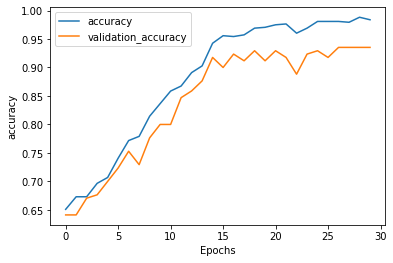

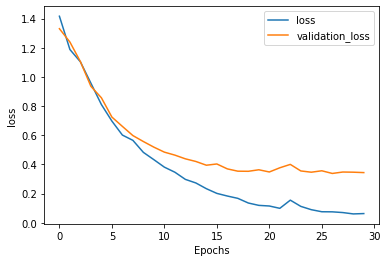

In [92]:
#plotting accuracy and loss history
plot_history(history, string = 'accuracy')
plot_history(history, string = 'loss')

In [93]:
#final accuracy on dev set for final model
from sklearn.metrics import accuracy_score
print("Accuracy of final model: ")
print(accuracy_score(labels_pred,y_test_label_seq))

Accuracy of final model: 
0.9352941176470588
